# 知识工程-作业1 

2024214500 叶璨铭


## 环境配置和`结巴`库安装

```bash
conda activate yuequ
pip install uv
uv pip install jieba sklearn tqdm # uv的pip速度比 pip 快，不过配置清华源的方式不同。
```

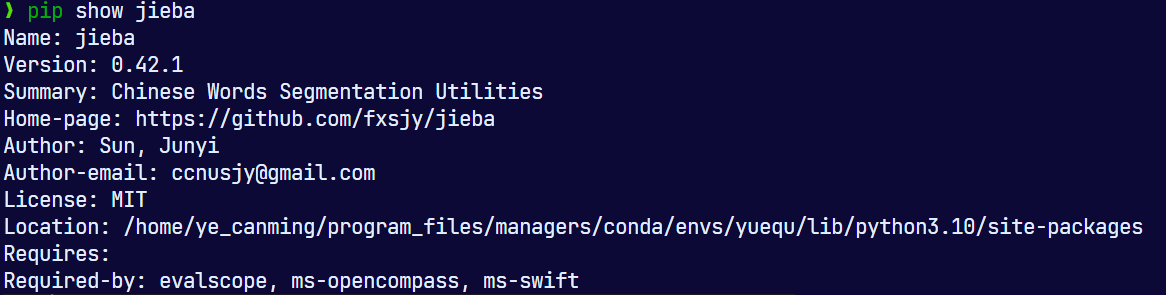


## 4:1 划分数据集为训练集和验证集

注意到助教给出的main代码中已经有对应的实现，比如`main_cut.py`中
```python
# 训练集验证集划分
random.seed(19260817)
random.shuffle(corpus)
train_size = round(len(corpus) * 4 / 5)
train_set, valid_set = corpus[:train_size], corpus[train_size:]
print("Train:", len(train_set), ", Valid:", len(valid_set))
```
先对corpus这个list进行了打乱，然后取前4/5作为训练集，后1/5作为验证集。
我们也可以用sklearn去做这个事情，不过这里就不再赘述了。

## 分词算法的核心代码实现

首先我们阅读 `main_cut.py` 熟悉一下整体流程。

从import来看，我们需要实现这些函数才能跑通这个main。
```python
from util.cut_util import maximum_match_cut, get_final_result, jieba_cut, evaluate
```